Reference paper: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

#### Metric Learning (learning a distance metric between individuals)

- Siamese Network (contrastive loss) = pairs of images where each pair consists of either similar or dissimilar images are used to train the network to distinguish items. 

In [1]:
!pip install lightning torch==1.10.1 torchaudio==0.10.1 torchvision==0.11.2 pytorch-lightning==1.9.0 lightning-utilities==0.10.1 Pillow
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
  Using cached lightning-2.3.3-py3-none-any.whl (808 kB)
  Using cached torch-1.10.1-cp38-cp38-manylinux1_x86_64.whl (881.9 MB)
  Using cached torchaudio-0.10.1-cp38-cp38-manylinux1_x86_64.whl (2.9 MB)
  Using cached torchvision-0.11.2-cp38-cp38-manylinux1_x86_64.whl (23.3 MB)
  Using cached pytorch_lightning-1.9.0-py3-none-any.whl (825 kB)
  Using cached lightning_utilities-0.10.1-py3-none-any.whl (24 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Using cached torchmetrics-1.4.2-py3-none-any.whl (869 kB)
  Using cached lightning-2.3.2-py3-none-any.whl (2.0 MB)
  Using cached lightning-2.3.1-py3-none-any.whl (2.0 MB)
  Using cached lightning-2.3.0-py3-none-any.whl (2.0 MB)
  Using cached lightning-2.2.5-py3-none-any.whl (2.0 MB)
  Using cached lightning-2.2.4-py3-none-any.whl (2.0 MB)
  Using cached lightning-2.2.3-py3-none-any.whl (2.0 MB)
  Using cached lightning-2.2.2-py3-none-any.whl (2.0 

  Using cached protobuf-5.28.2-cp38-abi3-manylinux2014_x86_64.whl (316 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached pygments-2.18.0-py3-none-any.whl (1.2 MB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Using cached aiohappyeyeballs-2.4.3-py3-none-any.whl (14 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.3/318.3 KB 11.5 MB/s eta 0:00:00
  Using cached frozenlist-1.4.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (240 kB)
  Using cached multidict-6.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (129 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)
  Using cached exceptiongroup-1.2.2-py3-none-any.whl (16 kB)
  Using cached xmod-1

Directory Structure and Data Loading to ensure a clear path to images and CSV files.

<pre>
IndividualTigerID/
│
├── reid_data/
│   ├── reference/                          # Directory for reference files
│   │   ├── (reference images)              
│   │   └── reid_reference.csv
│   │
│   ├── test/                               # Directory for test images
│   │   ├── (images for testing)
│   │   └── reid_test.csv
│   │
│   └── train/                              # Directory for training images
│       ├── (images for training)
│       ├── reid_train.csv
│       └── 
│
</pre>


### Datasets
To store the samples and their corresponding labels.

Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [1]:
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import random
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

class TigerReIDDataset(Dataset):
    """
    This class handles the loading and preprocessing of tiger images for both
    Siamese and Triplet network approaches. It supports only training mode, 
    and can generate image pairs or triplets as per network architecture.
    """

    def __init__(self, img_dir, transform=None, mode='siamese'):
        """
        Initialize the TigerReIDDataset.
        
        Args:
            img_dir (str): Directory containing images and the annotation CSV file.
            transform (callable, optional): Optional transform to be applied on images.
            mode (str): 'siamese' (Siamese Network) or 'triplet' (Triplet Network) mode for generating pairs or triplets.
        """
        
        self.img_dir = img_dir
        self.transform = transform
        self.mode = mode
        
        # Load the annotations CSV file
        self.annotations = pd.read_csv(os.path.join(img_dir, 'reid_train.csv'))
        self.img_folder = img_dir

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.annotations)

    def __getitem__(self, idx):
        """
        Retrieve a sample from the dataset.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            A pair of images for Siamese mode, or a triplet of images for Triplet mode.
        
        Raises:
            ValueError: If the mode is neither 'siamese' nor 'triplet'.
        """
        if self.mode == 'siamese':
            return self._get_siamese_pair(idx)
        elif self.mode == 'triplet':
            return self._get_triplet(idx)
        else:
            raise ValueError("Mode must be either 'siamese' or 'triplet'")

    def _get_image(self, img_name):
        """
        Load and preprocess an image.
        
        Args:
            img_name (str): Filename of the image to load.
        
        Returns:
            The loaded and preprocessed image.
        """
        # Construct the full path to the image
        img_path = os.path.join(self.img_folder, img_name)
        # Open the image and convert it to RGB
        image = Image.open(img_path).convert('RGB')
        # Apply any specified transforms
        if self.transform:
            image = self.transform(image)
        return image

    def _get_siamese_pair(self, idx):
        """
        Get a pair of images for Siamese network training.
        
        Args:
            idx (int): Index of the anchor image.
        
        Returns:
            (anchor_image, pair_image, label)
        """
        # Get the row corresponding to the anchor image
        anchor_row = self.annotations.iloc[idx]
        anchor_img = self._get_image(anchor_row['file_name'])

        # Randomly decide whether to create a positive or negative pair
        if random.random() > 0.5:  # Positive pair (same ID)
            # Select another image of the same tiger
            positive_row = self.annotations[self.annotations['id'] == anchor_row['id']].sample().iloc[0]
            pair_img = self._get_image(positive_row['file_name'])
            label = 1  # Same tiger
        else:  # Negative pair (different ID)
            # Select an image of a different tiger
            negative_row = self.annotations[self.annotations['id'] != anchor_row['id']].sample().iloc[0]
            pair_img = self._get_image(negative_row['file_name'])
            label = 0  # Different tiger
        
        return anchor_img, pair_img, label

    def _get_triplet(self, idx):
        """
        Get a triplet of images for Triplet network training.
        
        Args:
            idx (int): Index of the anchor image.
        
        Returns:
            (anchor_image, positive_image, negative_image)
        """
        # Get the row corresponding to the anchor image
        anchor_row = self.annotations.iloc[idx]
        anchor_img = self._get_image(anchor_row['file_name'])

        # Select a positive sample (same tiger, different image)
        positive_row = self.annotations[(self.annotations['id'] == anchor_row['id']) & (self.annotations.index != idx)].sample().iloc[0]
        # Select a negative sample (different tiger)
        negative_row = self.annotations[self.annotations['id'] != anchor_row['id']].sample().iloc[0]

        positive_img = self._get_image(positive_row['file_name'])
        negative_img = self._get_image(negative_row['file_name'])
        
        return anchor_img, positive_img, negative_img

#### Transformation 1: Input image dimensions must be uniform, typically 224x224 for ResNet50 CNN backbone.

Reference: https://github.com/microsoft/CameraTraps/blob/762657b0fcfbae4671cdb99dc2f19b1749b01cf7/PytorchWildlife/data/transforms.py#L125

#### Transformation 2: Preserve the aspect ratio of the original image
(If time permits)

We can preserve the aspect ratio while resizing images by padding them with zeros, ensuring that the tigers' features remain undistorted during the resizing process.

In [2]:
import torchvision.transforms as transforms

# The transformation resizes images to a default target size of 224x224, normalizes them based on ImageNet's mean and standard deviation values, and converts them into tensors.
def resize_transform(target_size=224):
    """
    Creates a transformation pipeline to preprocess images for ResNet-50.

    Args:
        target_size (int): Desired size for the height and width after resizing.
    
    Returns:
        torchvision.transforms.Compose: Transformation pipeline for image preprocessing.
    """
    # Define the mean and standard deviation for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Create the transformation sequence
    transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    return transform

# Define the custom transformation. This would stretch the image but maintain the exact required size.
resize_transform = resize_transform(target_size=224)

# ResNet-50 Backbone CNN to generate embeddings

## Architecture of the Pre-trained Classifier

as defined by our Capstone project primary paper "PyTorch-Wildlife" GitHub repository.

References:
- https://github.com/microsoft/CameraTraps/blob/main/PW_FT_classification/src/models/plain_resnet.py
- https://github.com/microsoft/CameraTraps/blob/main/PW_FT_classification/src/algorithms/plain.py

In [3]:
print(torch.cuda.is_available())  # Returns True if GPU is accessible

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


In [4]:
# Importing libraries
import torch.nn as nn  # Module for building neural network layers
from torchvision.models.resnet import Bottleneck, ResNet  # ResNet architecture components

# Define a custom ResNet backbone
class ResNetBackbone(ResNet):
    def __init__(self, block, layers, **kwargs):
        super(ResNetBackbone, self).__init__(block=block, layers=layers, **kwargs)

    def _forward_impl(self, x):
        # Forward pass through the ResNet backbone
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the output for classification
        return x

# Define the main classifier using the ResNet backbone
class PlainResNetClassifier(nn.Module):
    def __init__(self, num_cls=2, num_layers=50):
        super(PlainResNetClassifier, self).__init__()
        self.num_cls = num_cls
        self.num_layers = num_layers

        # Initialize the network
        self.setup_net()

    def setup_net(self):
        block = Bottleneck  # Bottleneck block for ResNet
        layers = [3, 4, 6, 3]  # Number of layers in each ResNet block

        # Constructing the feature extractor and classifier
        self.feature = ResNetBackbone(block, layers)  # Feature extractor
        self.classifier = nn.Linear(512 * block.expansion, self.num_cls)  # Classifier layer
    
    def forward(self, x):
        x = self.feature(x)  # Pass through the feature extractor
        x = self.classifier(x)  # Pass through the classifier
        return x

In [5]:
from torchsummary import summary

# Instantiate the model without pre-trained weights
pw_resnet50 = PlainResNetClassifier(num_cls=2, num_layers=50)

# Load weights directly from the checkpoint
checkpoint_path = 'weights/Crop/Plain/Crop_res50_plain_082723-0-epoch=14-valid_mac_acc=91.38.ckpt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
pw_resnet50.load_state_dict(checkpoint['state_dict'], strict=False)

# Print the model architecture summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pw_resnet50.to(device)
summary(pw_resnet50, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [6]:
import torch
import torch.nn as nn

# Define the feature extraction model by removing the classification layer
feature_extractor = nn.Sequential(*list(pw_resnet50.children())[:-1])  # Remove the last FC layer

# Add a Dense layer
feature_extractor.add_module('fc', nn.Linear(in_features=2048, out_features=512))

# Print the model architecture summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)
summary(feature_extractor, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### DataLoaders
To wrap an iterable around the Dataset to enable easy access to the samples. We have loaded the dataset into the DataLoader and each iteration returns a batch of train_features and train_labels. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting. DataLoader is an iterable that abstracts this complexity.

# Siamese Network

The objective is to develop an embedding in which the distance between similar samples is smaller than the distance between dissimilar ones.

In [7]:
from torch.utils.data import DataLoader

# For Siamese Network
train_dataset_siamese = TigerReIDDataset(img_dir='reid_data/train', mode='siamese', transform=resize_transform)
train_loader_siamese = DataLoader(train_dataset_siamese, batch_size=32, shuffle=True)  # Set shuffle to True for training

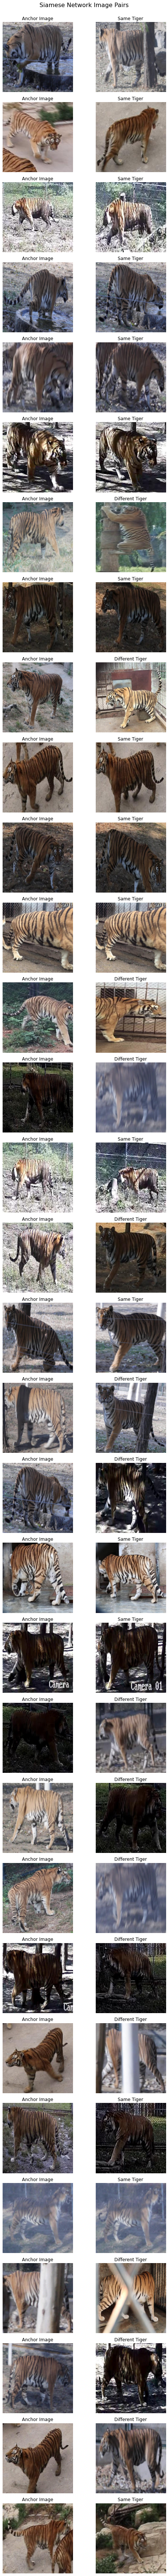

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_siamese_batch(batch):
    """
    Show a batch of images with their corresponding labels.
    
    Args:
        batch: A tuple containing (anchor_images, pair_images, labels)
    """
    
    # Unpack the batch into anchor images, pair images, and labels
    anchor_images, pair_images, labels = batch
    batch_size = len(anchor_images)
    
    # Create a figure with subplots: each row will show an anchor image and its pair
    fig, axes = plt.subplots(batch_size, 2, figsize=(8, 3 * batch_size))
    fig.suptitle("Siamese Network Image Pairs", fontsize=16, y=1)
    
    # Loop through each image in the batch
    for i in range(batch_size):
        for j, img in enumerate([anchor_images[i], pair_images[i]]):
            # Select the appropriate axis for the current image
            if batch_size == 1:
                ax = axes[j]  # If batch size is 1, use a single axis
            else:
                ax = axes[i, j]  # Otherwise, use the 2D grid of axes
            
            # Convert from PyTorch tensor to NumPy array and transpose dimensions for display
            img_np = img.numpy().transpose((1, 2, 0))  # Change shape from (C, H, W) to (H, W, C)
            
            # Denormalize the image (undo normalization applied during preprocessing)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = std * img_np + mean
            img_np = np.clip(img_np, 0, 1)
            
            ax.imshow(img_np)
            ax.axis('off')
            
            # Set titles based on whether the images are from the same or different Tiger
            if j == 0:
                ax.set_title("Anchor Image")
            else:
                ax.set_title(f"{'Same' if labels[i] == 1 else 'Different'} Tiger")
    
    plt.tight_layout()
    plt.show()

# Get a batch of data
dataiter = iter(train_loader_siamese)
batch = next(dataiter)

# Show the batch
show_siamese_batch(batch)

## Siamese Architecture and ContrastiveLoss

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    """
    Siamese Network uses a shared feature extractor to process two inputs:
    - x1: First input image
    - x2: Second input image
    """
    def __init__(self, feature_extractor):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = feature_extractor   # Shared feature extractor for both inputs
        
    def forward_one(self, x):
        # Extract embeddings
        embedding = self.feature_extractor(x)
        return embedding
    
    def forward(self, x1, x2):
        # Extract embeddings for both inputs
        embedding1 = self.forward_one(x1)
        embedding2 = self.forward_one(x2)
        return embedding1, embedding2
    
    def get_distance(self, x1, x2):
        # Compute the pairwise distance between embeddings
        embedding1, embedding2 = self.forward(x1, x2)
        return F.pairwise_distance(embedding1, embedding2)

class ContrastiveLoss(nn.Module):
    """
    - Minimizing the distance between similar pairs (label=1).
    - Maximizing the distance between dissimilar pairs (label=0).
    """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, label):
        # Compute the squared distance between the embeddings
        euclidean_distance = F.pairwise_distance(embedding1, embedding2)
        
        # Calculate the contrastive loss
        loss_positive = label * torch.pow(euclidean_distance, 2)   # Calculate the loss for positive pairs (similar)
        loss_negative = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)   # Calculate the loss for negative pairs (dissimilar)

        return torch.mean(loss_positive + loss_negative)

In [10]:
# Initialize the Siamese Network with the feature_extractor to get embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_net = SiameseNetwork(feature_extractor).to(device)

# Define input size (2 inputs for Siamese network)
input_size = [(3, 224, 224), (3, 224, 224)]

# Print the model summary
summary(siamese_net, input_size=input_size, device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [27]:
import torch.optim as optim
from tqdm import tqdm

# Set up the optimizer and loss function
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)
criterion = ContrastiveLoss(margin=1.0).to(device)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
def train(epochs):
    for epoch in range(epochs):
        siamese_net.train()   # Set the model to training mode
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader_siamese), total=len(train_loader_siamese), desc=f"Epoch [{epoch+1}/{epochs}]")
        
        for i, (anchor_img, pair_img, label) in progress_bar:
            anchor_img, pair_img, label = anchor_img.to(device), pair_img.to(device), label.to(device) # Move data to the device
            
            optimizer.zero_grad()
            embedding_anchor, embedding_pair = siamese_net(anchor_img, pair_img)   # Forward pass
            
            # Calculate the loss
            loss = criterion(embedding_anchor, embedding_pair, label)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            progress_bar.set_postfix({'loss': f"{running_loss/(i+1):.4f}"})
        
        scheduler.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader_siamese):.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

# Train the model
train(epochs=55)

Epoch [1/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=2.6466]


Epoch [1/60], Loss: 2.6466, LR: 0.001000


Epoch [2/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.2864]


Epoch [2/60], Loss: 0.2864, LR: 0.001000


Epoch [3/60]: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s, loss=0.2435]


Epoch [3/60], Loss: 0.2435, LR: 0.001000


Epoch [4/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.1594]


Epoch [4/60], Loss: 0.1594, LR: 0.001000


Epoch [5/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.1389]


Epoch [5/60], Loss: 0.1389, LR: 0.001000


Epoch [6/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.1457]


Epoch [6/60], Loss: 0.1457, LR: 0.001000


Epoch [7/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.1372]


Epoch [7/60], Loss: 0.1372, LR: 0.001000


Epoch [8/60]: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.1465]


Epoch [8/60], Loss: 0.1465, LR: 0.001000


Epoch [9/60]: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.1392]


Epoch [9/60], Loss: 0.1392, LR: 0.001000


Epoch [10/60]: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s, loss=0.1128]


Epoch [10/60], Loss: 0.1128, LR: 0.000500


Epoch [11/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.1045]


Epoch [11/60], Loss: 0.1045, LR: 0.000500


Epoch [12/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.1063]


Epoch [12/60], Loss: 0.1063, LR: 0.000500


Epoch [13/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0924]


Epoch [13/60], Loss: 0.0924, LR: 0.000500


Epoch [14/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0986]


Epoch [14/60], Loss: 0.0986, LR: 0.000500


Epoch [15/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0940]


Epoch [15/60], Loss: 0.0940, LR: 0.000500


Epoch [16/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0972]


Epoch [16/60], Loss: 0.0972, LR: 0.000500


Epoch [17/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0976]


Epoch [17/60], Loss: 0.0976, LR: 0.000500


Epoch [18/60]: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.0944]


Epoch [18/60], Loss: 0.0944, LR: 0.000500


Epoch [19/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.1188]


Epoch [19/60], Loss: 0.1188, LR: 0.000500


Epoch [20/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.1007]


Epoch [20/60], Loss: 0.1007, LR: 0.000250


Epoch [21/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0891]


Epoch [21/60], Loss: 0.0891, LR: 0.000250


Epoch [22/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0873]


Epoch [22/60], Loss: 0.0873, LR: 0.000250


Epoch [23/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0850]


Epoch [23/60], Loss: 0.0850, LR: 0.000250


Epoch [24/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0804]


Epoch [24/60], Loss: 0.0804, LR: 0.000250


Epoch [25/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0803]


Epoch [25/60], Loss: 0.0803, LR: 0.000250


Epoch [26/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0809]


Epoch [26/60], Loss: 0.0809, LR: 0.000250


Epoch [27/60]: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.0796]


Epoch [27/60], Loss: 0.0796, LR: 0.000250


Epoch [28/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0807]


Epoch [28/60], Loss: 0.0807, LR: 0.000250


Epoch [29/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0816]


Epoch [29/60], Loss: 0.0816, LR: 0.000250


Epoch [30/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0780]


Epoch [30/60], Loss: 0.0780, LR: 0.000125


Epoch [31/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0748]


Epoch [31/60], Loss: 0.0748, LR: 0.000125


Epoch [32/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0726]


Epoch [32/60], Loss: 0.0726, LR: 0.000125


Epoch [33/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0666]


Epoch [33/60], Loss: 0.0666, LR: 0.000125


Epoch [34/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0669]


Epoch [34/60], Loss: 0.0669, LR: 0.000125


Epoch [35/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0700]


Epoch [35/60], Loss: 0.0700, LR: 0.000125


Epoch [36/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0635]


Epoch [36/60], Loss: 0.0635, LR: 0.000125


Epoch [37/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0722]


Epoch [37/60], Loss: 0.0722, LR: 0.000125


Epoch [38/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0656]


Epoch [38/60], Loss: 0.0656, LR: 0.000125


Epoch [39/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0660]


Epoch [39/60], Loss: 0.0660, LR: 0.000125


Epoch [40/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0673]


Epoch [40/60], Loss: 0.0673, LR: 0.000063


Epoch [41/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0660]


Epoch [41/60], Loss: 0.0660, LR: 0.000063


Epoch [42/60]: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.0607]


Epoch [42/60], Loss: 0.0607, LR: 0.000063


Epoch [43/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0595]


Epoch [43/60], Loss: 0.0595, LR: 0.000063


Epoch [44/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0629]


Epoch [44/60], Loss: 0.0629, LR: 0.000063


Epoch [45/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0642]


Epoch [45/60], Loss: 0.0642, LR: 0.000063


Epoch [46/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0609]


Epoch [46/60], Loss: 0.0609, LR: 0.000063


Epoch [47/60]: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s, loss=0.0621]


Epoch [47/60], Loss: 0.0621, LR: 0.000063


Epoch [48/60]: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s, loss=0.0627]


Epoch [48/60], Loss: 0.0627, LR: 0.000063


Epoch [49/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0595]


Epoch [49/60], Loss: 0.0595, LR: 0.000063


Epoch [50/60]: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.0587]


Epoch [50/60], Loss: 0.0587, LR: 0.000031


Epoch [51/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0572]


Epoch [51/60], Loss: 0.0572, LR: 0.000031


Epoch [52/60]: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.0588]


Epoch [52/60], Loss: 0.0588, LR: 0.000031


Epoch [53/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0553]


Epoch [53/60], Loss: 0.0553, LR: 0.000031


Epoch [54/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0568]


Epoch [54/60], Loss: 0.0568, LR: 0.000031


Epoch [55/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0568]


Epoch [55/60], Loss: 0.0568, LR: 0.000031


Epoch [56/60]: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.0569]


Epoch [56/60], Loss: 0.0569, LR: 0.000031


Epoch [57/60]: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s, loss=0.0536]


Epoch [57/60], Loss: 0.0536, LR: 0.000031


Epoch [58/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0605]


Epoch [58/60], Loss: 0.0605, LR: 0.000031


Epoch [59/60]: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s, loss=0.0555]


Epoch [59/60], Loss: 0.0555, LR: 0.000031


Epoch [60/60]: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s, loss=0.0556]

Epoch [60/60], Loss: 0.0556, LR: 0.000016


### Testing the Siamese model with an image

The re-identification process ranks the similarity between two images (the test image and the images in the tiger database) by comparing each test image with all the images in the reference set.

In [28]:
import pandas as pd
import torch
from PIL import Image
import torch.nn.functional as F

# Define the function for comparing test images with reference images
def compare_with_references(test_img_path, reference_df, model, transform, device):
    """
    Compares a test image with reference images using a trained Siamese network.

    Args:
        test_img_path (str): File path of the test image.
        reference_df (pd.DataFrame): DataFrame containing reference image paths and tiger IDs.
        model (torch.nn.Module): Trained Siamese network model.
        transform (callable): Transformations to be applied to the images.
        device (torch.device): Device to perform computations (CPU or GPU).

    Returns:
        pd.DataFrame: DataFrame with distances between the test image and all reference images,
                      along with their tiger IDs and filenames.
    """
    # Load and preprocess the test image
    test_img = Image.open(test_img_path).convert('RGB')
    test_img = transform(test_img).unsqueeze(0).to(device)
    
    # Extract test image filename and ID from the path
    test_filename = os.path.basename(test_img_path)
    test_id = test_df[test_df['file_name'] == test_filename]['id'].values[0]
    
    # Store distances and related information
    results = {'Reference Filename': [], 'Reference ID': [], 'Distance': []}
    
    # Iterate over each reference image
    for idx, row in reference_df.iterrows():
        # Load and preprocess the reference image
        reference_img_path = os.path.join('reid_data', 'reference', row['file_name'])
        reference_img = Image.open(reference_img_path).convert('RGB')
        reference_img = transform(reference_img).unsqueeze(0).to(device)

        # Calculate distance between test and reference images
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            distance = model.get_distance(test_img, reference_img).item()  # Calculate the pairwise distance

        # Store results
        results['Reference Filename'].append(row['file_name'])
        results['Reference ID'].append(row['id'])
        results['Distance'].append(distance)
    
    # Create a DataFrame to store distances and sort them in ascending order
    distances_df = pd.DataFrame(results)
    distances_df = distances_df.sort_values(by='Distance', ascending=True).reset_index(drop=True)
    
    # Add the test image's filename and ID to the output
    print(f"Test Image Filename: {test_filename}")
    print(f"Test Image Tiger ID: {test_id}")
    
    return distances_df

# Define the test image path
test_img_path = 'reid_data/test/001305.jpg'  # Replace with a test image path

# Define paths to the test and reference CSV files
test_csv_path = 'reid_data/test/reid_test.csv'
reference_csv_path = 'reid_data/reference/reid_reference.csv'

# Load the test and reference CSV files
test_df = pd.read_csv(test_csv_path)
reference_df = pd.read_csv(reference_csv_path)

# Compare the test image with reference images and get the distances
distances_df = compare_with_references(test_img_path, reference_df, siamese_net, resize_transform, device)

# Print the top 10 closest matches, along with the test image details
print("Top 10 Closest Matches:")
distances_df.head(10)

Test Image Filename: 001305.jpg
Test Image Tiger ID: 154
Top 10 Closest Matches:


Reference Filename  Reference ID  Distance
0         001251.jpg           154  0.188678
1         004971.jpg           154  0.211280
2         001842.jpg           154  0.232894
3         002504.jpg           154  0.248596
4         003967.jpg           154  0.254697
5         004561.jpg           154  0.271227
6         000212.jpg           154  0.289695
7         003080.jpg           154  0.386662
8         001737.jpg           172  0.403000
9         002631.jpg           172  0.433840

### Visual representation of the previous code block

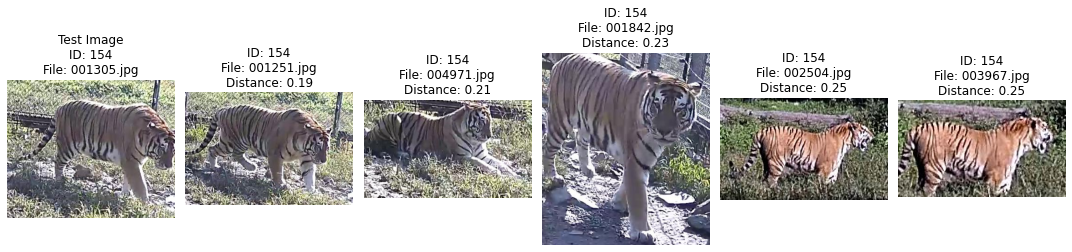

In [29]:
import matplotlib.pyplot as plt

def visualize_matches(test_img_path, distances_df, num_matches=5):
    """
    Visualizes the test image and its closest matches from the reference dataset.

    Args:
        test_img_path (str): File path of the test image.
        distances_df (pd.DataFrame): DataFrame containing distances and reference image details.
        num_matches (int): Number of closest matches to display.
    """
    # Load and display the test image
    test_img = Image.open(test_img_path).convert('RGB')

    # Extract details from the distances DataFrame for the test image
    test_filename = os.path.basename(test_img_path)
    test_id = test_df[test_df['file_name'] == test_filename]['id'].values[0]

    # Plot setup
    fig, axes = plt.subplots(1, num_matches + 1, figsize=(15, 5))
    
    # Display the test image in the first column
    axes[0].imshow(test_img)
    axes[0].set_title(f"Test Image\nID: {test_id}\nFile: {test_filename}")
    axes[0].axis('off')

    # Display top 'num_matches' closest reference images
    for i in range(num_matches):
        # Get reference image filename and load it
        ref_img_filename = distances_df.iloc[i]['Reference Filename']
        ref_img_path = os.path.join('reid_data', 'reference', ref_img_filename)
        ref_img = Image.open(ref_img_path).convert('RGB')
        
        # Get reference ID and distance
        ref_id = distances_df.iloc[i]['Reference ID']
        ref_distance = distances_df.iloc[i]['Distance']
        
        # Plot reference image
        axes[i + 1].imshow(ref_img)
        axes[i + 1].set_title(f"ID: {ref_id}\nFile: {ref_img_filename}\nDistance: {ref_distance:.2f}")
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the test image against the top 5 closest matches
visualize_matches(test_img_path, distances_df, num_matches=5)

# Performance: Mean Average Precision mAP@k (ranking quality metric)

Mean Average Precision (MAP) at K is a metric used to evaluate ranking and recommender systems. It helps determine whether the predicted items are relevant and how well the image retrieval system positions the most relevant items at the top of the list for a given query. MAP can take values from 0 to 1, where 1 corresponds to an ideal ranking with all relevant items at the top. The closer the MAP score is to 1, the better is the performance.

Reference: https://www.evidentlyai.com/ranking-metrics/mean-average-precision-map

The system provides 'N' potential candidates, from which the user can manually select the relevant Tiger individual. Each individual tiger can be identified by comparing the encoding of a tiger from the query (test) image to the encoded representations of identified tigers stored in a labeled database. These encoding vectors only need to be computed once for each tiger in the reference (gallery) database, allowing for efficient comparison and reducing computational effort during identification.

In [30]:
# Function to generate embeddings
def extract_embeddings(df, image_dir, model, transform, device):
    embeddings = []
    image_ids = []
    
    model.eval()
    
    with torch.no_grad():
        for _, row in df.iterrows():
            img_file = row['file_name']
            img_path = os.path.join(image_dir, img_file)
            
            # Open and transform the image
            image = Image.open(img_path).convert('RGB')
            image = transform(image).unsqueeze(0)
            image = image.to(device)
            
            # Extract embedding using the Siamese network's feature extractor
            embedding = model.forward_one(image).cpu().numpy().flatten()
            
            # Store the embedding and corresponding ID
            embeddings.append(embedding)
            image_ids.append(row['id'])
    
    return np.array(embeddings), np.array(image_ids)

# Paths to test and reference CSV annotation files
test_csv_path = 'reid_data/test/reid_test.csv'
reference_csv_path = 'reid_data/reference/reid_reference.csv'

# Load CSV files
test_df = pd.read_csv(test_csv_path)
reference_df = pd.read_csv(reference_csv_path)

# Extract embeddings for test and reference images
test_image_dir = 'reid_data/test'
reference_image_dir = 'reid_data/reference'

test_embeddings, test_ids = extract_embeddings(test_df, test_image_dir, siamese_net, resize_transform, device)
reference_embeddings, reference_ids = extract_embeddings(reference_df, reference_image_dir, siamese_net, resize_transform, device)

mAP considers both the rank order and the relevance of the retrieved images. It aggregates the Average Precision (AP) across all query images, giving a single performance measure for the retrieval system.

In [31]:
# Function to compute Euclidean distance between two embeddings
def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

# Evaluate the Siamese network model using MAPK metric
results = []

# Calculate distances and prepare ranked predictions for each test image
for query_idx, query_embedding in enumerate(test_embeddings):
    distances = []
    
    # Compute distance of the query image to each reference image
    for ref_idx, ref_embedding in enumerate(reference_embeddings):
        dist = euclidean_distance(query_embedding, ref_embedding)
        distances.append((ref_idx, dist))
    
    # Sort distances by ascending order
    distances.sort(key=lambda x: x[1])
    
    # Extract top-K predictions
    k = 7  # Set maximum K for top-K extraction
    top_k_indices = [distances[i][0] for i in range(min(k, len(distances)))]  # Ensure we do not exceed the number of distances
    
    # Extract corresponding query ID
    query_id = test_ids[query_idx]
    
    # Check relevance for each top-K prediction and prepare the DataFrame
    for rank, ref_idx in enumerate(top_k_indices, 1):
        predicted_id = reference_ids[ref_idx]
        relevance = 1 if query_id == predicted_id else 0
        
        results.append({
            "query_id": query_id,         # test image ID
            "predicted_id": predicted_id, # Reference image ID
            "rank": rank,                 # Rank of the predicted item
            "relevance": relevance        # 1 if relevant, 0 otherwise
        })

# Convert results into DataFrame for MAPK metric
results_df = pd.DataFrame(results)

results_df

query_id  predicted_id  rank  relevance
0          153           160     1          0
1          153           153     2          1
2          153           160     3          0
3          153           153     4          1
4          153           153     5          1
...        ...           ...   ...        ...
2165        42            42     3          1
2166        42            42     4          1
2167        42            42     5          1
2168        42            42     6          1
2169        42            42     7          1

[2170 rows x 4 columns]

In [32]:
# Calculate the precision at K (the number of top results to consider)
def precision_at_k(relevance, k):
    return np.sum(relevance[:k]) / k  # Return the ratio of relevant items in the top k

# Calculate the Average Precision at K
def average_precision_at_k(relevance, k):
    if sum(relevance) == 0:
        return 0.0  # If there are no relevant items, return 0
    
    score = 0.0  # Initialize score to accumulate precision values
    num_hits = 0.0  # Initialize the count of relevant items found
    
    # Iterate over the top K results
    for i in range(min(len(relevance), k)):
        if relevance[i] == 1:  # If the item is relevant
            num_hits += 1.0  # Increment the count of hits
            score += num_hits / (i + 1.0)  # Add precision at this position to the score
    
    return score / min(sum(relevance), k)  # Return the average precision, which is the score normalized by the number of relevant items

# Calculate Mean Average Precision at K across all queries
# results_df: DataFrame containing query results with columns 'query_id', 'rank', and 'relevance'
def mean_average_precision_at_k(results_df, k):
    ap_scores = []  # List to hold Average Precision scores for each query
    
    # Iterate through each unique query ID in the DataFrame
    for query_id in results_df['query_id'].unique():
        # Get the results for the current query, sorted by rank (top K)
        query_results = results_df[results_df['query_id'] == query_id].sort_values('rank')
        relevance = query_results['relevance'].values[:k] # Get the relevance scores for the top K results
        
        # Calculate the Average Precision for this query and append to the scores list
        ap = average_precision_at_k(relevance, k)
        ap_scores.append(ap)
    
    return np.mean(ap_scores)  # Return the mean of all Average Precision scores

# Define the K values to evaluate
k_values = [1, 3, 5, 7]

# Calculate MAP@K for different values of K
for k in k_values:
    map_k = mean_average_precision_at_k(results_df, k)  # Calculate MAP@K
    print(f"MAP@{k}: {map_k:.4f}")

MAP@1: 0.7290
MAP@3: 0.7952
MAP@5: 0.7983
MAP@7: 0.7941
